# Fault Merging Analysis

This notebook analyzes fault classification on merged fault scenarios where multiple fault types are combined to understand their interactions and impact on detection performance.

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from typing import Dict, List, Tuple
from collections import Counter

# Data preparation imports
import pyreadr
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from tabulate import tabulate

In [18]:
# Configuration
VERSION = "1.00"
OUTPUT_PATH = "output"

In [19]:
def save_plot(plot_name: str, suffix: str = "", plot_path: str = "FaultMerging") -> None:
    """Save current matplotlib figure."""
    timestamp: str = ""
    base_dir: str = os.path.join(OUTPUT_PATH, "data", plot_path)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{plot_name}_{suffix}_v{VERSION}_{timestamp}.png" if suffix else f"{plot_name}_v{VERSION}_{timestamp}.png"
    filepath: str = os.path.join(base_dir, filename)

    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    print(f"Plot saved: {filepath}")

def save_dataframe(df: pd.DataFrame, name: str, suffix: str = "") -> None:
    """Save a DataFrame to CSV."""
    timestamp: str = ""
    base_dir: str = os.path.join(OUTPUT_PATH, "data")
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.csv" if suffix else f"{name}_v{VERSION}_{timestamp}.csv"
    filepath: str = os.path.join(base_dir, filename)

    df.to_csv(filepath, index=True)
    print(f"Data saved: {filepath}")

def save_pickle(obj, name: str, suffix: str = "") -> None:
    """Save object as pickle file."""
    timestamp: str = ""
    base_dir: str = os.path.join(OUTPUT_PATH, "data")
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.pkl" if suffix else f"{name}_v{VERSION}_{timestamp}.pkl"
    filepath: str = os.path.join(base_dir, filename)

    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Results saved: {filepath}")

## Load Prepared Data

In [20]:
# ====================================================================
# STANDALONE FAULT MERGING DATA PREPARATION
# ====================================================================

print("=== STANDALONE FAULT MERGING DATA PREPARATION ===")
print("Preparing data with merged fault scenarios for classification analysis...")

# Configuration for fault merging
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = ["simulationRun", "sample"]
SKIPED_FAULTS = []
FAULTS_TO_BE_MERGED_TOGETHER = [3, 8, 9, 18, 15]  # Faults to merge into one class
MERGE_FAULTS_TO_NUMBER = 3  # Merge the above faults to this fault number

# Load raw data
print("Loading raw data files...")
fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
fault_free_testing_dict = pyreadr.read_r("data/TEP_FaultFree_Testing.RData")
faulty_training_dict = pyreadr.read_r("data/TEP_Faulty_Training.RData")
faulty_testing_dict = pyreadr.read_r("data/TEP_Faulty_Testing.RData")

# Extract DataFrames
DF_FF_TRAINING_RAW = fault_free_training_dict["fault_free_training"]
DF_FF_TEST_RAW = fault_free_testing_dict["fault_free_testing"]
DF_F_TRAINING_RAW = faulty_training_dict["faulty_training"]
DF_F_TEST_RAW = faulty_testing_dict["faulty_testing"]

print(f"✓ Raw data loaded: Train Fault-free {DF_FF_TRAINING_RAW.shape}, Train Faulty {DF_F_TRAINING_RAW.shape}")

# Skip specified faults (if any)
DF_F_TRAIN_SKIPPED = DF_F_TRAINING_RAW[~DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)
DF_F_TEST_SKIPPED = DF_F_TEST_RAW[~DF_F_TEST_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)

# Reduce data for development
DF_FF_TRAINING_REDUCED = DF_FF_TRAINING_RAW[(DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                           (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 3)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TRAINING_REDUCED = DF_F_TRAIN_SKIPPED[(DF_F_TRAIN_SKIPPED[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                          (DF_F_TRAIN_SKIPPED[SIMULATION_RUN_COLUMN_NAME] < 3)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

DF_FF_TEST_REDUCED = DF_FF_TEST_RAW[(DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                   (DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] < 3)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TEST_REDUCED = DF_F_TEST_SKIPPED[(DF_F_TEST_SKIPPED[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                     (DF_F_TEST_SKIPPED[SIMULATION_RUN_COLUMN_NAME] < 3)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

print(f"✓ Data reduced for fault merging analysis")

# Apply fault merging logic
print(f"✓ Merging faults {FAULTS_TO_BE_MERGED_TOGETHER} into fault class {MERGE_FAULTS_TO_NUMBER}")

# Merge faults for training data
Y_TRAIN_MERGED_DF = DF_F_TRAINING_REDUCED[TARGET_VARIABLE_COLUMN_NAME].apply(
    lambda x: MERGE_FAULTS_TO_NUMBER if x in FAULTS_TO_BE_MERGED_TOGETHER else x
)
# Add fault-free labels
Y_TRAIN_MERGED_FF = DF_FF_TRAINING_REDUCED[TARGET_VARIABLE_COLUMN_NAME]
Y_TRAIN_MERGED_DF = pd.concat([Y_TRAIN_MERGED_FF, Y_TRAIN_MERGED_DF], ignore_index=True)

# Merge faults for test data
Y_TEST_MERGED_DF = DF_F_TEST_REDUCED[TARGET_VARIABLE_COLUMN_NAME].apply(
    lambda x: MERGE_FAULTS_TO_NUMBER if x in FAULTS_TO_BE_MERGED_TOGETHER else x
)
# Add fault-free labels
Y_TEST_MERGED_FF = DF_FF_TEST_REDUCED[TARGET_VARIABLE_COLUMN_NAME]
Y_TEST_MERGED_DF = pd.concat([Y_TEST_MERGED_FF, Y_TEST_MERGED_DF], ignore_index=True)

# Concatenate features
DF_TRAINING_MERGED = pd.concat([DF_FF_TRAINING_REDUCED, DF_F_TRAINING_REDUCED], ignore_index=True)
DF_TEST_MERGED = pd.concat([DF_FF_TEST_REDUCED, DF_F_TEST_REDUCED], ignore_index=True)

# Prepare features for merged fault analysis
X_TRAIN_MERGED = DF_TRAINING_MERGED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1).to_numpy()
X_TEST_MERGED = DF_TEST_MERGED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1).to_numpy()

# Standardize features
scaler_merged = StandardScaler()
X_TRAIN_MERGED = scaler_merged.fit_transform(X_TRAIN_MERGED)
X_TEST_MERGED = scaler_merged.transform(X_TEST_MERGED)

# One-hot encode merged labels
onehot_encoder_merged = OneHotEncoder(sparse_output=False)
Y_train_merged_reshaped = Y_TRAIN_MERGED_DF.to_numpy().reshape(-1, 1)
Y_ENC_TRAIN_MERGED = onehot_encoder_merged.fit_transform(Y_train_merged_reshaped)

Y_test_merged_reshaped = Y_TEST_MERGED_DF.to_numpy().reshape(-1, 1)
Y_ENC_TEST_MERGED = onehot_encoder_merged.transform(Y_test_merged_reshaped)

print(f"✓ Fault merging complete:")
print(f"✓ Training data shape: {X_TRAIN_MERGED.shape}")
print(f"✓ Test data shape: {X_TEST_MERGED.shape}")
print(f"✓ Number of unique merged fault classes: {len(Y_TRAIN_MERGED_DF.unique())}")
print(f"✓ Original fault numbers: {sorted(DF_F_TRAINING_REDUCED[TARGET_VARIABLE_COLUMN_NAME].unique())}")
print(f"✓ Merged fault numbers: {sorted(Y_TRAIN_MERGED_DF.unique())}")
print(f"✓ Class distribution in training set:")
print(Y_TRAIN_MERGED_DF.value_counts().sort_index().to_dict())
print("=== FAULT MERGING DATA PREPARATION COMPLETE ===\n")

=== STANDALONE FAULT MERGING DATA PREPARATION ===
Preparing data with merged fault scenarios for classification analysis...
Loading raw data files...
✓ Raw data loaded: Train Fault-free (250000, 55), Train Faulty (5000000, 55)
✓ Raw data loaded: Train Fault-free (250000, 55), Train Faulty (5000000, 55)
✓ Data reduced for fault merging analysis
✓ Merging faults [3, 8, 9, 18, 15] into fault class 3
✓ Fault merging complete:
✓ Training data shape: (21000, 52)
✓ Test data shape: (40320, 52)
✓ Number of unique merged fault classes: 17
✓ Original fault numbers: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20)]
✓ Merged fault numbers: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.fl

## Exploratory Analysis of Merged Faults

In [21]:
def analyze_fault_combinations(y_labels: pd.Series) -> pd.DataFrame:
    """Analyze the combinations of faults in merged classes."""
    fault_combinations = []
    
    for fault_class in y_labels.unique():
        if fault_class == 0:  # Normal class
            fault_combinations.append({
                'Class': fault_class,
                'Fault_Types': 'Normal',
                'Num_Faults': 0,
                'Count': (y_labels == fault_class).sum()
            })
        else:
            # Extract individual fault numbers from class name/number
            fault_str = str(fault_class)
            if len(fault_str) == 1:
                # Single fault
                fault_types = f"Fault {fault_str}"
                num_faults = 1
            else:
                # Multiple faults - assume digits represent fault numbers
                individual_faults = [f"Fault {digit}" for digit in fault_str]
                fault_types = " + ".join(individual_faults)
                num_faults = len(individual_faults)
            
            fault_combinations.append({
                'Class': fault_class,
                'Fault_Types': fault_types,
                'Num_Faults': num_faults,
                'Count': (y_labels == fault_class).sum()
            })
    
    return pd.DataFrame(fault_combinations).sort_values('Count', ascending=False)

fault_analysis = analyze_fault_combinations(Y_TRAIN_MERGED_DF)
print("Fault Combination Analysis:")
print(tabulate(fault_analysis, headers="keys", tablefmt="grid"))

save_dataframe(fault_analysis, "fault_combinations_analysis", "merging")

Fault Combination Analysis:
+----+---------+---------------------------------------+--------------+---------+
|    |   Class | Fault_Types                           |   Num_Faults |   Count |
+====+=========+=======================================+==============+=========+
|  3 |       3 | Fault 3 + Fault . + Fault 0           |            3 |    5000 |
+----+---------+---------------------------------------+--------------+---------+
|  0 |       0 | Normal                                |            0 |    1000 |
+----+---------+---------------------------------------+--------------+---------+
|  9 |      11 | Fault 1 + Fault 1 + Fault . + Fault 0 |            4 |    1000 |
+----+---------+---------------------------------------+--------------+---------+
| 15 |      19 | Fault 1 + Fault 9 + Fault . + Fault 0 |            4 |    1000 |
+----+---------+---------------------------------------+--------------+---------+
| 14 |      17 | Fault 1 + Fault 7 + Fault . + Fault 0 |            4 

Plot saved: output/data/FaultMerging/merged_fault_distribution_v1.00_.png


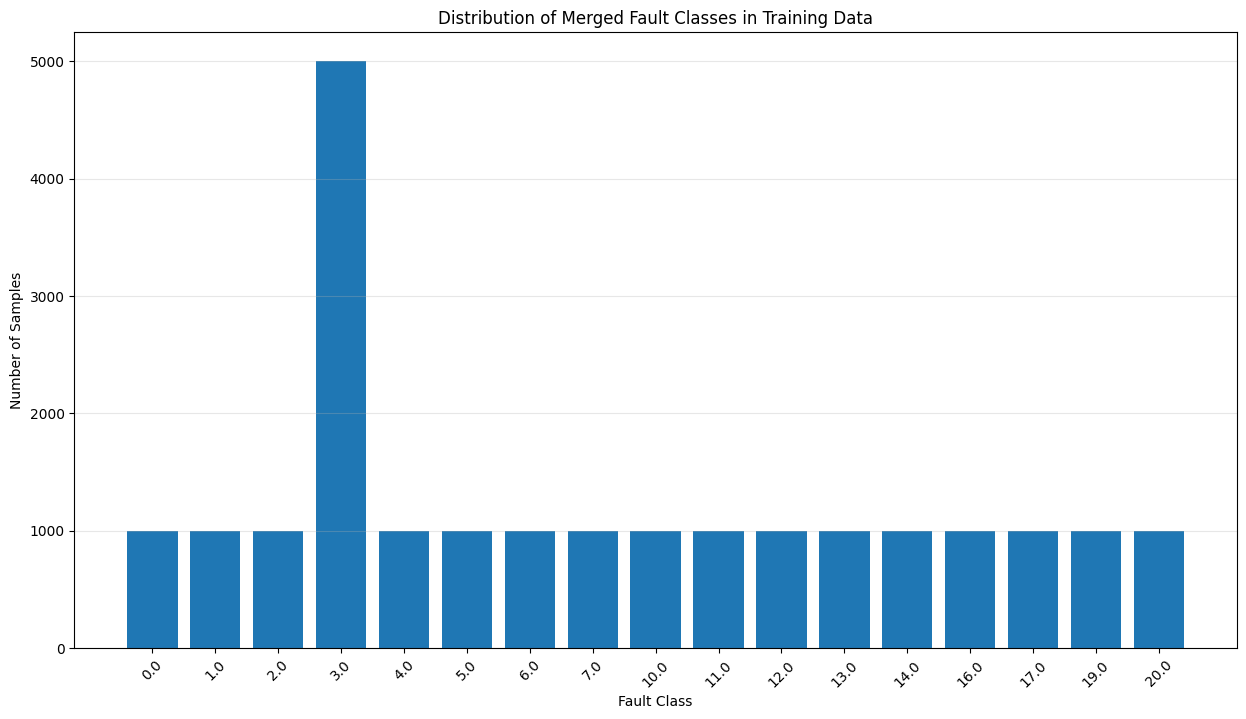

Plot saved: output/data/FaultMerging/fault_complexity_distribution_v1.00_.png


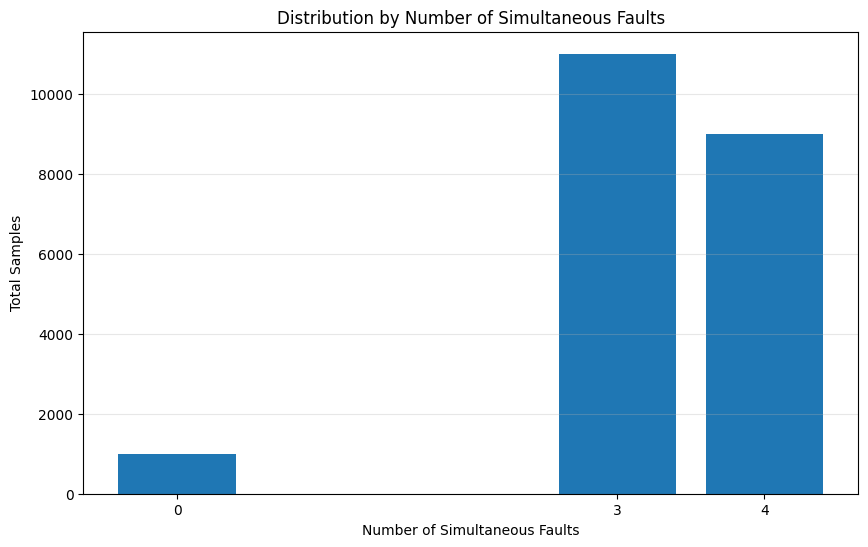

In [22]:
# Plot class distribution
plt.figure(figsize=(15, 8))
class_counts = Y_TRAIN_MERGED_DF.value_counts().sort_index()
plt.bar(range(len(class_counts)), class_counts.values)
plt.xlabel('Fault Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Merged Fault Classes in Training Data')
plt.xticks(range(len(class_counts)), class_counts.index, rotation=45)
plt.grid(axis='y', alpha=0.3)
save_plot('merged_fault_distribution')
plt.show()

# Plot number of faults per combination
plt.figure(figsize=(10, 6))
fault_counts = fault_analysis.groupby('Num_Faults')['Count'].sum()
plt.bar(fault_counts.index, fault_counts.values)
plt.xlabel('Number of Simultaneous Faults')
plt.ylabel('Total Samples')
plt.title('Distribution by Number of Simultaneous Faults')
plt.xticks(fault_counts.index)
plt.grid(axis='y', alpha=0.3)
save_plot('fault_complexity_distribution')
plt.show()

## Evaluation Functions

In [23]:
def compute_multiclass_metrics(y_true, y_pred, model_name: str) -> pd.DataFrame:
    """Compute comprehensive multiclass classification metrics."""
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics from classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Extract macro and weighted averages
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Macro_Precision': [macro_avg['precision']],
        'Macro_Recall': [macro_avg['recall']],
        'Macro_F1': [macro_avg['f1-score']],
        'Weighted_Precision': [weighted_avg['precision']],
        'Weighted_Recall': [weighted_avg['recall']],
        'Weighted_F1': [weighted_avg['f1-score']]
    })
    
    return metrics_df

def analyze_per_class_performance(y_true, y_pred, model_name: str) -> pd.DataFrame:
    """Analyze per-class performance metrics."""
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    per_class_metrics = []
    for class_label, metrics in report.items():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            per_class_metrics.append({
                'Model': model_name,
                'Class': class_label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            })
    
    return pd.DataFrame(per_class_metrics)

## Model Training and Evaluation

In [24]:
# Initialize results storage
merged_results_per_model: Dict[str, pd.DataFrame] = {}
merged_per_class_results: Dict[str, pd.DataFrame] = {}
trained_models_merged: Dict[str, object] = {}

### 1. Random Forest

In [25]:
print("Training Random Forest for merged fault classification...")

# Train model
rf_merged = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_merged.fit(X_TRAIN_MERGED, Y_TRAIN_MERGED_DF)
y_pred_rf_merged = rf_merged.predict(X_TEST_MERGED)

# Evaluate
rf_merged_metrics = compute_multiclass_metrics(Y_TEST_MERGED_DF, y_pred_rf_merged, "Random Forest")
rf_merged_per_class = analyze_per_class_performance(Y_TEST_MERGED_DF, y_pred_rf_merged, "Random Forest")

merged_results_per_model["Random Forest"] = rf_merged_metrics
merged_per_class_results["Random Forest"] = rf_merged_per_class
trained_models_merged["Random Forest"] = rf_merged

print(f"Random Forest - Accuracy: {rf_merged_metrics['Accuracy'].values[0]:.3f}")
print(f"Random Forest - Macro F1: {rf_merged_metrics['Macro_F1'].values[0]:.3f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': range(len(rf_merged.feature_importances_)),
    'Importance': rf_merged.feature_importances_
}).sort_values('Importance', ascending=False)

save_dataframe(feature_importance_rf.head(20), "rf_feature_importance", "merging")

Training Random Forest for merged fault classification...


Random Forest - Accuracy: 0.692
Random Forest - Macro F1: 0.691
Data saved: output/data/rf_feature_importance_merging_v1.00_.csv


### 2. XGBoost

In [26]:
print("Training XGBoost for merged fault classification...")

# Explicitly delete any existing XGBoost model to avoid class conflicts
if 'xg_merged' in globals():
    del xg_merged

# Create mapping for non-consecutive class labels to consecutive ones
unique_classes = sorted(Y_TRAIN_MERGED_DF.unique())
class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
reverse_mapping = {new_class: old_class for old_class, new_class in class_mapping.items()}

print(f"Original classes: {unique_classes}")
print(f"Class mapping: {class_mapping}")

# Map training and test labels to consecutive integers
Y_TRAIN_MAPPED = Y_TRAIN_MERGED_DF.map(class_mapping)
Y_TEST_MAPPED = Y_TEST_MERGED_DF.map(class_mapping)

# Create a completely fresh XGBoost model
xg_merged = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train model with mapped labels
xg_merged.fit(X_TRAIN_MERGED, Y_TRAIN_MAPPED)
y_pred_xg_mapped = xg_merged.predict(X_TEST_MERGED)

# Map predictions back to original class labels
y_pred_xg_merged = pd.Series(y_pred_xg_mapped).map(reverse_mapping)

# Evaluate using original labels
xg_merged_metrics = compute_multiclass_metrics(Y_TEST_MERGED_DF, y_pred_xg_merged, "XGBoost")
xg_merged_per_class = analyze_per_class_performance(Y_TEST_MERGED_DF, y_pred_xg_merged, "XGBoost")

merged_results_per_model["XGBoost"] = xg_merged_metrics
merged_per_class_results["XGBoost"] = xg_merged_per_class
trained_models_merged["XGBoost"] = xg_merged

print(f"XGBoost - Accuracy: {xg_merged_metrics['Accuracy'].values[0]:.3f}")
print(f"XGBoost - Macro F1: {xg_merged_metrics['Macro_F1'].values[0]:.3f}")

# Feature importance
feature_importance_xg = pd.DataFrame({
    'Feature': range(len(xg_merged.feature_importances_)),
    'Importance': xg_merged.feature_importances_
}).sort_values('Importance', ascending=False)

save_dataframe(feature_importance_xg.head(20), "xgb_feature_importance", "merging")

Training XGBoost for merged fault classification...
Original classes: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0), np.float64(19.0), np.float64(20.0)]
Class mapping: {np.float64(0.0): 0, np.float64(1.0): 1, np.float64(2.0): 2, np.float64(3.0): 3, np.float64(4.0): 4, np.float64(5.0): 5, np.float64(6.0): 6, np.float64(7.0): 7, np.float64(10.0): 8, np.float64(11.0): 9, np.float64(12.0): 10, np.float64(13.0): 11, np.float64(14.0): 12, np.float64(16.0): 13, np.float64(17.0): 14, np.float64(19.0): 15, np.float64(20.0): 16}
XGBoost - Accuracy: 0.678
XGBoost - Macro F1: 0.691
Data saved: output/data/xgb_feature_importance_merging_v1.00_.csv
XGBoost - Accuracy: 0.678
XGBoost - Macro F1: 0.691
Data saved: output/data/xgb_feature_importance_merging_v1.00_.csv


### 3. Neural Network

In [27]:
print("Training Neural Network for merged fault classification...")

# Define model
inputs = Input(shape=(X_TRAIN_MERGED.shape[1],))
x = Dense(256, activation="relu")(inputs)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(Y_ENC_TEST_MERGED.shape[1], activation="softmax")(x)

model_merged_nn = Model(inputs=inputs, outputs=outputs)
model_merged_nn.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_merged = model_merged_nn.fit(
    X_TRAIN_MERGED,
    Y_ENC_TRAIN_MERGED,
    epochs=100,
    batch_size=128,
    validation_data=(X_TEST_MERGED, Y_ENC_TEST_MERGED),
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred_merged_nn_proba = model_merged_nn.predict(X_TEST_MERGED, verbose=0)
y_pred_merged_nn = onehot_encoder_merged.inverse_transform(y_pred_merged_nn_proba)

# Evaluate
nn_merged_metrics = compute_multiclass_metrics(Y_TEST_MERGED_DF, y_pred_merged_nn, "Neural Network")
nn_merged_per_class = analyze_per_class_performance(Y_TEST_MERGED_DF, y_pred_merged_nn, "Neural Network")

merged_results_per_model["Neural Network"] = nn_merged_metrics
merged_per_class_results["Neural Network"] = nn_merged_per_class
trained_models_merged["Neural Network"] = model_merged_nn

print(f"Neural Network - Accuracy: {nn_merged_metrics['Accuracy'].values[0]:.3f}")
print(f"Neural Network - Macro F1: {nn_merged_metrics['Macro_F1'].values[0]:.3f}")

Training Neural Network for merged fault classification...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3528 - loss: 2.1982 - val_accuracy: 0.5175 - val_loss: 1.7080
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3528 - loss: 2.1982 - val_accuracy: 0.5175 - val_loss: 1.7080
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6291 - loss: 1.2383 - val_accuracy: 0.6073 - val_loss: 1.7579
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6291 - loss: 1.2383 - val_accuracy: 0.6073 - val_loss: 1.7579
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.9325 - val_accuracy: 0.6136 - val_loss: 1.7688
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.9325 - val_accuracy: 0.6136 - val_loss: 1.7688
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - loss: 0.8036 - val_accuracy: 0.6262 - val_loss: 2.3342
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━

## Results Analysis and Visualization

In [28]:
# Combine overall results
def convert_result_dict_to_df(results_dict):
    """Convert results dictionary to DataFrame."""
    return pd.concat(list(results_dict.values()), ignore_index=True)

concatenated_merged_results_df = convert_result_dict_to_df(merged_results_per_model)
save_dataframe(concatenated_merged_results_df, "merged_fault_classification_metrics", "merging")

print("\n=== Merged Fault Classification Results ===")
print(tabulate(concatenated_merged_results_df, headers="keys", tablefmt="grid", floatfmt=".3f"))

Data saved: output/data/merged_fault_classification_metrics_merging_v1.00_.csv

=== Merged Fault Classification Results ===
+----+----------------+------------+-------------------+----------------+------------+----------------------+-------------------+---------------+
|    | Model          |   Accuracy |   Macro_Precision |   Macro_Recall |   Macro_F1 |   Weighted_Precision |   Weighted_Recall |   Weighted_F1 |
+====+================+============+===================+================+============+======================+===================+===============+
|  0 | Random Forest  |      0.692 |             0.785 |          0.639 |      0.691 |                0.727 |             0.692 |         0.680 |
+----+----------------+------------+-------------------+----------------+------------+----------------------+-------------------+---------------+
|  1 | XGBoost        |      0.678 |             0.778 |          0.646 |      0.691 |                0.716 |             0.678 |         0.670 |


Data saved: output/data/merged_fault_per_class_metrics_merging_v1.00_.csv
Plot saved: output/data/FaultMerging/merged_fault_model_comparison_v1.00_.png


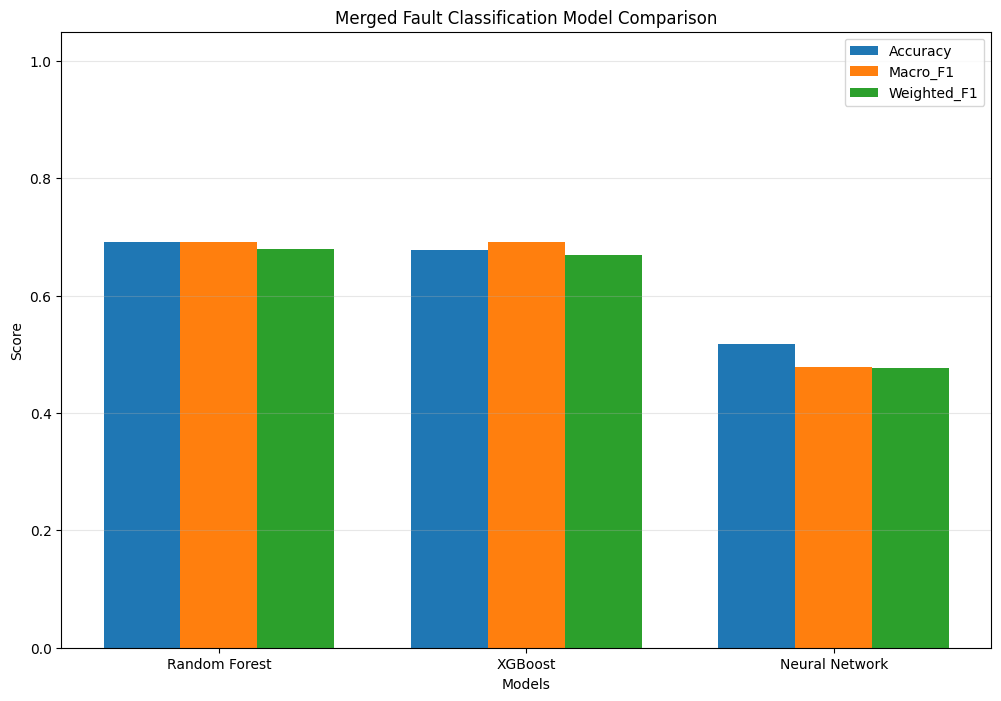

In [29]:
# Combine per-class results
all_per_class_results = pd.concat(list(merged_per_class_results.values()), ignore_index=True)
save_dataframe(all_per_class_results, "merged_fault_per_class_metrics", "merging")

# Plot overall model comparison
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Macro_F1', 'Weighted_F1']
x = np.arange(len(concatenated_merged_results_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, concatenated_merged_results_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Merged Fault Classification Model Comparison')
plt.xticks(x + width, concatenated_merged_results_df['Model'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
save_plot('merged_fault_model_comparison')
plt.show()

Plot saved: output/data/FaultMerging/per_class_f1_random_forest_v1.00_.png


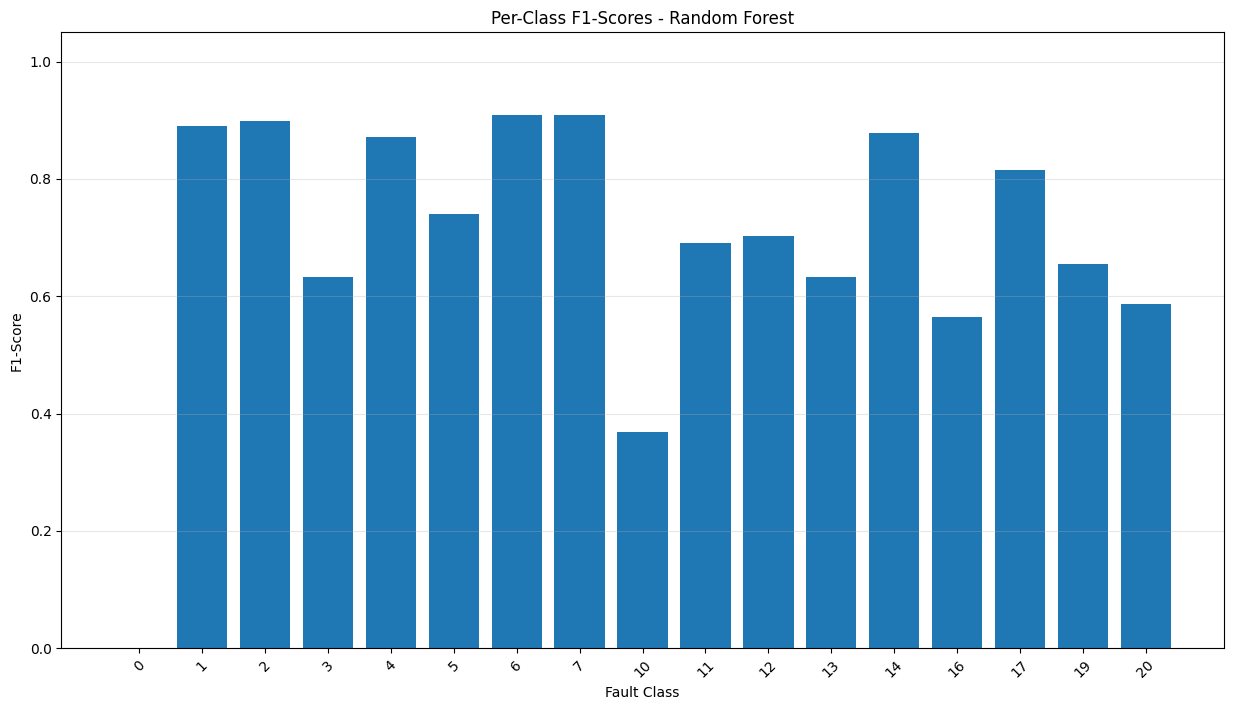

In [30]:
# Plot per-class F1-scores for best model
best_model_idx = concatenated_merged_results_df['Accuracy'].idxmax()
best_model_name = concatenated_merged_results_df.loc[best_model_idx, 'Model']
best_model_per_class = merged_per_class_results[best_model_name]

plt.figure(figsize=(15, 8))
plt.bar(range(len(best_model_per_class)), best_model_per_class['F1-Score'])
plt.xlabel('Fault Class')
plt.ylabel('F1-Score')
plt.title(f'Per-Class F1-Scores - {best_model_name}')
plt.xticks(range(len(best_model_per_class)), best_model_per_class['Class'], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
save_plot(f'per_class_f1_{best_model_name.lower().replace(" ", "_")}')
plt.show()

Plot saved: output/data/FaultMerging/confusion_matrix_random_forest_v1.00_.png


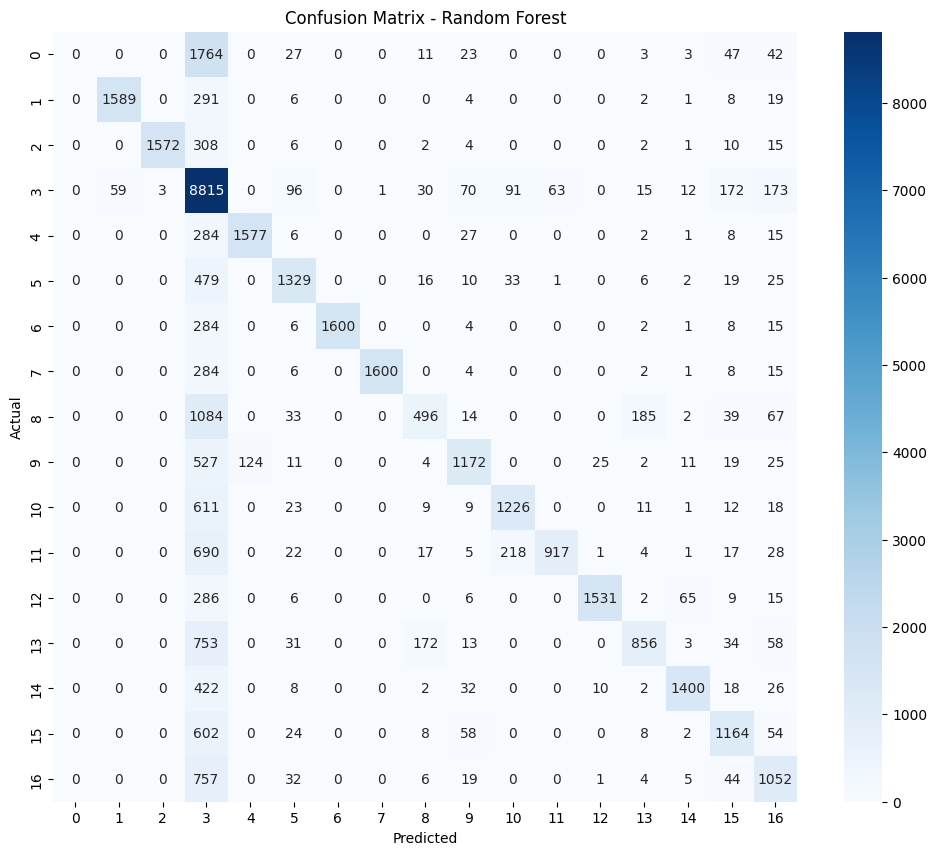

In [31]:
# Plot confusion matrix for best model
def plot_confusion_matrix_multiclass(y_true, y_pred, model_name: str):
    """Plot confusion matrix for multiclass classification."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    safe_name = model_name.lower().replace(' ', '_')
    save_plot(f'confusion_matrix_{safe_name}')
    plt.show()

if best_model_name == "Random Forest":
    y_pred_best = y_pred_rf_merged
elif best_model_name == "XGBoost":
    y_pred_best = y_pred_xg_merged
else:
    y_pred_best = y_pred_merged_nn

plot_confusion_matrix_multiclass(Y_TEST_MERGED_DF, y_pred_best, best_model_name)

## Cross-Validation Analysis


Performing cross-validation analysis...


/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Plot saved: output/data/FaultMerging/cross_validation_results_v1.00_.png


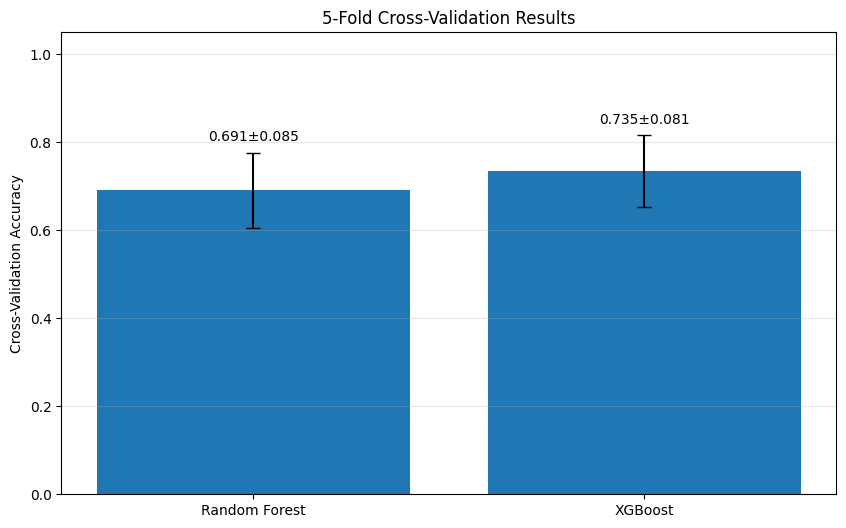

Cross-validation results:
Random Forest: 0.691 ± 0.085
XGBoost: 0.735 ± 0.081


In [34]:
# Perform cross-validation for robust performance assessment
print("\nPerforming cross-validation analysis...")

cv_results = {}

# Random Forest CV
rf_cv_scores = cross_val_score(rf_merged, X_TRAIN_MERGED, Y_TRAIN_MERGED_DF, 
                              cv=5, scoring='accuracy', n_jobs=-1)
cv_results['Random Forest'] = {
    'mean': rf_cv_scores.mean(),
    'std': rf_cv_scores.std(),
    'scores': rf_cv_scores
}

# XGBoost CV - use mapped labels since XGBoost was trained with consecutive integers
xg_cv_scores = cross_val_score(xg_merged, X_TRAIN_MERGED, Y_TRAIN_MAPPED, 
                              cv=5, scoring='accuracy', n_jobs=-1)
cv_results['XGBoost'] = {
    'mean': xg_cv_scores.mean(),
    'std': xg_cv_scores.std(),
    'scores': xg_cv_scores
}

# Plot CV results
plt.figure(figsize=(10, 6))
models = list(cv_results.keys())
means = [cv_results[model]['mean'] for model in models]
stds = [cv_results[model]['std'] for model in models]

plt.bar(models, means, yerr=stds, capsize=5)
plt.ylabel('Cross-Validation Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
             ha='center', va='bottom')

save_plot('cross_validation_results')
plt.show()

print("Cross-validation results:")
for model, results in cv_results.items():
    print(f"{model}: {results['mean']:.3f} ± {results['std']:.3f}")

## Fault Complexity Analysis

Plot saved: output/data/FaultMerging/performance_by_complexity_v1.00_.png


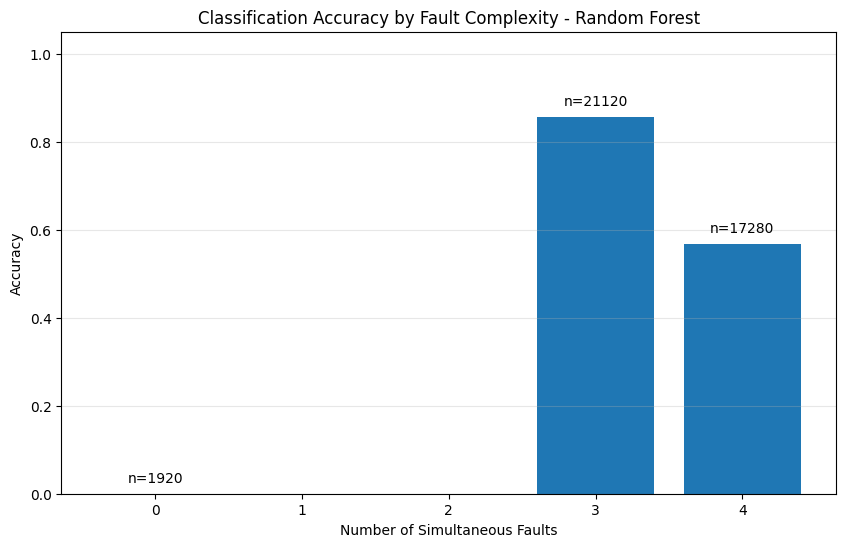

Performance by fault complexity:
3 fault(s): 0.856 accuracy (21120 samples)
0 fault(s): 0.000 accuracy (1920 samples)
4 fault(s): 0.568 accuracy (17280 samples)


In [35]:
def analyze_performance_by_complexity(y_true, y_pred, fault_analysis_df):
    """Analyze performance by fault complexity (number of simultaneous faults)."""
    # Create mapping from class to number of faults
    class_to_complexity = dict(zip(fault_analysis_df['Class'], fault_analysis_df['Num_Faults']))
    
    # Group predictions by complexity
    complexity_results = {}
    
    for complexity in fault_analysis_df['Num_Faults'].unique():
        # Find classes with this complexity
        classes_with_complexity = fault_analysis_df[fault_analysis_df['Num_Faults'] == complexity]['Class'].tolist()
        
        # Filter predictions for these classes
        mask = y_true.isin(classes_with_complexity)
        if mask.sum() > 0:
            y_true_subset = y_true[mask]
            y_pred_subset = y_pred[mask]
            
            accuracy = accuracy_score(y_true_subset, y_pred_subset)
            complexity_results[complexity] = {
                'accuracy': accuracy,
                'samples': len(y_true_subset)
            }
    
    return complexity_results

# Analyze performance by complexity for best model
complexity_analysis = analyze_performance_by_complexity(Y_TEST_MERGED_DF, y_pred_best, fault_analysis)

# Plot performance vs complexity
plt.figure(figsize=(10, 6))
complexities = sorted(complexity_analysis.keys())
accuracies = [complexity_analysis[c]['accuracy'] for c in complexities]
sample_counts = [complexity_analysis[c]['samples'] for c in complexities]

bars = plt.bar(complexities, accuracies)
plt.xlabel('Number of Simultaneous Faults')
plt.ylabel('Accuracy')
plt.title(f'Classification Accuracy by Fault Complexity - {best_model_name}')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)

# Add sample count labels
for bar, count in zip(bars, sample_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'n={count}', ha='center', va='bottom')

save_plot('performance_by_complexity')
plt.show()

print("Performance by fault complexity:")
for complexity, results in complexity_analysis.items():
    print(f"{complexity} fault(s): {results['accuracy']:.3f} accuracy ({results['samples']} samples)")

## Export Results Summary

In [36]:
# Save models
for model_name, model_obj in trained_models_merged.items():
    safe_name = model_name.lower().replace(" ", "_")
    save_pickle(model_obj, f"merged_fault_model_{safe_name}")

# Create comprehensive results summary
best_accuracy = concatenated_merged_results_df['Accuracy'].max()
best_macro_f1 = concatenated_merged_results_df['Macro_F1'].max()
best_weighted_f1 = concatenated_merged_results_df['Weighted_F1'].max()

results_summary = {
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'best_macro_f1': float(best_macro_f1),
    'best_weighted_f1': float(best_weighted_f1),
    'models_trained': list(merged_results_per_model.keys()),
    'total_test_samples': int(len(Y_TEST_MERGED_DF)),
    'num_classes': int(len(Y_TEST_MERGED_DF.unique())),
    'cross_validation_results': {model: float(results['mean']) for model, results in cv_results.items()},
    'complexity_analysis': {int(k): v for k, v in complexity_analysis.items()}
}

# Save results summary
import json
summary_path = os.path.join(OUTPUT_PATH, VERSION, f"merged_fault_analysis_summary_v{VERSION}_.json")
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n=== Merged Fault Analysis Complete ===")
print(f"Best performing model: {best_model_name}")
print(f"Best accuracy: {best_accuracy:.3f}")
print(f"Best macro F1-score: {best_macro_f1:.3f}")
print(f"Number of fault classes: {results_summary['num_classes']}")
print(f"Total test samples: {results_summary['total_test_samples']}")
print(f"\nResults saved to: {OUTPUT_PATH}/{VERSION}/")
print("Files generated:")
print("- merged_fault_classification_metrics_merging_*.csv")
print("- merged_fault_per_class_metrics_merging_*.csv")
print("- fault_combinations_analysis_merging_*.csv")
print("- merged_fault_analysis_summary_*.json")
print("- merged_fault_model_*.pkl (trained models)")
print("- Various plots in merging/ subfolder")

Results saved: output/data/merged_fault_model_random_forest_v1.00_.pkl
Results saved: output/data/merged_fault_model_xgboost_v1.00_.pkl
Results saved: output/data/merged_fault_model_neural_network_v1.00_.pkl

=== Merged Fault Analysis Complete ===
Best performing model: Random Forest
Best accuracy: 0.692
Best macro F1-score: 0.691
Number of fault classes: 17
Total test samples: 40320

Results saved to: output/1.00/
Files generated:
- merged_fault_classification_metrics_merging_*.csv
- merged_fault_per_class_metrics_merging_*.csv
- fault_combinations_analysis_merging_*.csv
- merged_fault_analysis_summary_*.json
- merged_fault_model_*.pkl (trained models)
- Various plots in merging/ subfolder
